In [3]:
#importing the libraries for dataset
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
import datetime
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

In [4]:
#Import daily train and test sets (from ARIMA time series models) to use for RRN-LTSM models
WTI_train = pd.read_csv('WTI_train.csv')
WTI_test = pd.read_csv('WTI_test.csv')
BRENT_train = pd.read_csv('BRENT_train.csv')
BRENT_test = pd.read_csv('BRENT_test.csv')

In [5]:
WTI_train['date'] = pd.to_datetime(WTI_train['date'],yearfirst=True)
WTI_test['date'] = pd.to_datetime(WTI_test['date'],yearfirst=True)
BRENT_train['date'] = pd.to_datetime(BRENT_train['date'],yearfirst=True)
BRENT_test['date'] = pd.to_datetime(BRENT_test['date'],yearfirst=True)
WTI_train= WTI_train.rename(columns={"WTI": "WTI_train"})
WTI_test= WTI_test.rename(columns={"WTI": "WTI_test"})
BRENT_train= BRENT_train.rename(columns={"BRENT": "BRENT_train"})
BRENT_test= BRENT_test.rename(columns={"BRENT": "BRENT_test"})
WTI_train.set_index('date')
WTI_train.index = pd.to_datetime(WTI_train['date'],yearfirst=True)
WTI_test.set_index('date')
WTI_test.index = pd.to_datetime(WTI_test['date'],yearfirst=True)
BRENT_train.set_index('date')
BRENT_test.index = pd.to_datetime(BRENT_test['date'],yearfirst=True)

In [6]:
WTI_train_data=WTI_train.iloc[:,1:2].values
WTI_test_data=WTI_test.iloc[:,1:2].values
BRENT_train_data=BRENT_train.iloc[:,1:2].values
BRENT_test_data=BRENT_test.iloc[:,1:2].values

In [7]:
#Scale and normalize the oil price data to (0, 1) values by creating a scalar object.   
scaler=MinMaxScaler(feature_range=(0,1))
WTI_scaled_train_data=scaler.fit_transform(WTI_train_data)
WTI_scaled_test_data=scaler.fit_transform(WTI_test_data)
BRENT_scaled_train_data=scaler.fit_transform(BRENT_train_data)
BRENT_scaled_test_data=scaler.fit_transform(BRENT_test_data)

In [8]:
print(WTI_scaled_train_data.shape, WTI_scaled_test_data.shape, BRENT_scaled_train_data.shape, BRENT_scaled_test_data.shape)

(7218, 1) (351, 1) (7218, 1) (351, 1)


# RNN-LTSM Model for WTI Daily Data

In [10]:
# Create a data structure with 90 time-steps and 1 output 
# WTI_X_train=[]
# WTI_y_train=[]
# for i in range(90,len(WTI_scaled_train_data)):
    #WTI_X_train.append(WTI_scaled_train_data[i-90:i,0])
    #WTI_y_train.append(WTI_scaled_train_data[i,0])

#Converting the data to the numpy array as it is expected by our RNN model
WTI_X_train=np.array(WTI_scaled_train_data)
WTI_y_train=np.array(WTI_scaled_train_data)    

#Reshaping training data to the following format (# values, # time steps, #1 dimensional output)
WTI_X_train=np.reshape(WTI_X_train,(WTI_X_train.shape[0],WTI_X_train.shape[1],1))
    

In [11]:
#Build the LTSM model (LTSM with 50 neurons and 4 hidden layers using the MSE loss function and the Adam stoachastic gradient descent optimizer)
#(See https://medium.com/ai-in-plain-english/time-series-forecasting-predicting-stock-prices-using-an-lstm-model-30d6f1ca2640)

WTI_model=Sequential()

#Adding the first layer and dropout regularization
WTI_model.add(LSTM(units=50,return_sequences=True,input_shape=(WTI_X_train.shape[1],1)))
WTI_model.add(Dropout(0.2))
#Second layer
WTI_model.add(LSTM(units=50,return_sequences=True))
WTI_model.add(Dropout(0.2))
#Third layer
WTI_model.add(LSTM(units=50,return_sequences=True))
WTI_model.add(Dropout(0.2))
#Fourth Layer
WTI_model.add(LSTM(units=50,return_sequences=False))
WTI_model.add(Dropout(0.2))
#Output Layer
WTI_model.add(Dense(units=1))

#Compiling the RNN model
WTI_model.compile(optimizer='adam',loss='mean_squared_error')

#fitting the RNN model on our training dataset
WTI_model.fit(WTI_X_train,WTI_y_train,epochs=100,batch_size=32)


Epoch 1/100
226/226 [==============================] - 2s 7ms/step - loss: 0.0232
Epoch 2/100
226/226 [==============================] - 2s 8ms/step - loss: 0.0018
Epoch 3/100
226/226 [==============================] - 1s 6ms/step - loss: 0.0015
Epoch 4/100
226/226 [==============================] - 2s 8ms/step - loss: 0.0013
Epoch 5/100
226/226 [==============================] - 2s 7ms/step - loss: 0.0012
Epoch 6/100
226/226 [==============================] - 2s 7ms/step - loss: 0.0012
Epoch 7/100
226/226 [==============================] - 2s 7ms/step - loss: 0.0011
Epoch 8/100
226/226 [==============================] - 2s 7ms/step - loss: 0.0011
Epoch 9/100
226/226 [==============================] - 2s 7ms/step - loss: 0.0010
Epoch 10/100
226/226 [==============================] - 2s 7ms/step - loss: 0.0011
Epoch 11/100
226/226 [==============================] - 2s 7ms/step - loss: 0.0011
Epoch 12/100
226/226 [==============================] - 1s 7ms/step - loss: 0.0010
Epoch 13/100


In [13]:
#Preparing and reshaping test data 
WTI_dataset_total=pd.concat((WTI_train["WTI_train"], WTI_test["WTI_test"]), axis=0)
WTI_inputs = WTI_dataset_total[len(WTI_dataset_total) - len(WTI_test_data):].values

WTI_inputs = WTI_inputs.reshape(-1,1)
WTI_inputs = scaler.transform(WTI_inputs)
#WTI_X_test = []
#for i in range(90, len(WTI_scaled_test_data)):
    #WTI_X_test.append(WTI_inputs[i-90:i, 0])
    
WTI_X_test = np.array(WTI_scaled_test_data)
WTI_X_test = np.reshape(WTI_X_test, (WTI_X_test.shape[0], WTI_X_test.shape[1], 1))
print(WTI_X_test.shape)


(351, 1, 1)


In [14]:
#Making predictions using the test test
prediction_index= WTI_test["date"]
WTI_predictions=WTI_model.predict(WTI_X_test)
WTI_predictions=scaler.inverse_transform(WTI_predictions)
WTI_predictions = pd.DataFrame(WTI_predictions,index=prediction_index.index)
WTI_predictions

,0
date,
2019-01-02,62.950127
2019-01-03,63.383297
2019-01-04,63.974545
2019-01-07,64.329941
2019-01-08,65.227654
...,...
2020-05-22,54.138775
2020-05-26,54.896389
2020-05-27,53.714596


In [33]:
#Calculate the model fit and accuracy scores of RNN-LTSM model for predicting WTI test data 
WTI_accuracy = metrics.r2_score(WTI_test_data, WTI_predictions)
WTI_MSE = metrics.mean_squared_error(WTI_test_data, WTI_predictions)

print(f'the RNN-LTSM Model Fit for predicting WTI oil price data is: R2 = {WTI_accuracy} and MSE = {WTI_MSE}')

the RNN-LTSM Model Fit for predicting WTI oil price data is: R2 = -0.3163557947475055 and MSE = 240.22010103104384


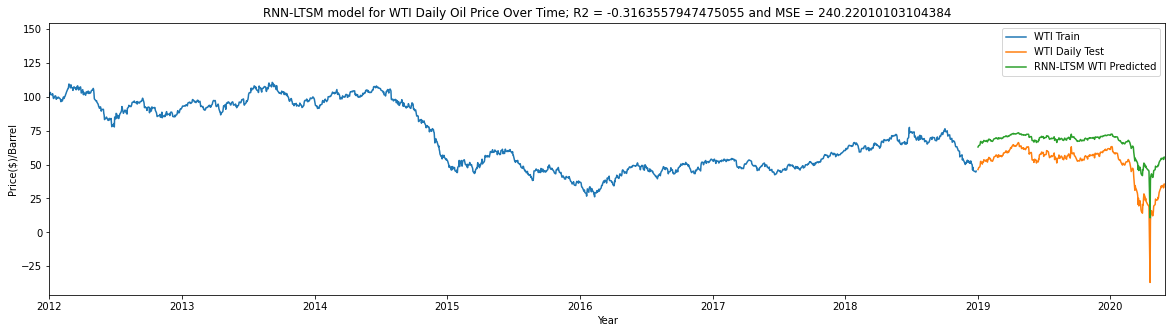

In [31]:
#Visualising the predictions and original data
plt.figure(figsize=(20,5))
plt.xlabel('Year')
plt.ylabel('Price($)/Barrel')
plt.plot(WTI_train["WTI_train"],label="WTI Train")
plt.plot(WTI_test["WTI_test"], label = "WTI Daily Test")
plt.plot(WTI_predictions, label = "RNN-LTSM WTI Predicted")
plt.title(f'RNN-LTSM model for WTI Daily Oil Price Over Time; R2 = {WTI_accuracy} and MSE = {WTI_MSE}')
plt.xlim([datetime.date(2012, 1, 1), datetime.date(2020, 6, 1)])
plt.legend()
plt.show()

# RNN-LTSM Model for BRENT Daily Data

In [34]:
# Create a data structure with 60 time-steps and 1 output 
BRENT_X_train=[]
BRENT_y_train=[]
for i in range(60,len(BRENT_scaled_train_data)):
    BRENT_X_train.append(BRENT_scaled_train_data[i-60:i,0])
    BRENT_y_train.append(BRENT_scaled_train_data[i,0])

#Converting the data to the numpy array as it is expected by our RNN model
BRENT_X_train=np.array(BRENT_X_train)
BRENT_y_train=np.array(BRENT_y_train)    

#Reshaping training data to the following format (# values, # time steps, #1 dimensional output)
BRENT_X_train=np.reshape(BRENT_X_train,(BRENT_X_train.shape[0],BRENT_X_train.shape[1],1))


In [ ]:
#Build the LTSM model (LTSM with 50 neurons and 4 hidden layers using the MSE loss function and the Adam stoachastic gradient descent optimizer)
#(See https://medium.com/ai-in-plain-english/time-series-forecasting-predicting-stock-prices-using-an-lstm-model-30d6f1ca2640)

BRENT_model=Sequential()

#Adding the first layer and dropout regularization
BRENT_model.add(LSTM(units=50,return_sequences=True,input_shape=(BRENT_X_train.shape[1],1)))
BRENT_model.add(Dropout(0.2))
#Second layer
BRENT_model.add(LSTM(units=50,return_sequences=True))
BRENT_model.add(Dropout(0.2))
#Third layer
BRENT_model.add(LSTM(units=50,return_sequences=True))
BRENT_model.add(Dropout(0.2))
#Fourth Layer
BRENT_model.add(LSTM(units=50,return_sequences=False))
BRENT_model.add(Dropout(0.2))
#Output Layer
BRENT_model.add(Dense(units=1))

#Compiling the RNN model
BRENT_model.compile(optimizer='adam',loss='mean_squared_error')

#fitting the RNN model on our training dataset
BRENT_model.fit(BRENT_X_train,BRENT_y_train,epochs=100,batch_size=32)


Epoch 1/100
224/224 [==============================] - 28s 123ms/step - loss: 0.0052
Epoch 2/100
224/224 [==============================] - 29s 131ms/step - loss: 0.0020
Epoch 3/100
224/224 [==============================] - 31s 140ms/step - loss: 0.0020
Epoch 4/100
224/224 [==============================] - 32s 141ms/step - loss: 0.0015
Epoch 5/100
224/224 [==============================] - 32s 143ms/step - loss: 0.0014
Epoch 6/100
224/224 [==============================] - 32s 142ms/step - loss: 0.0013
Epoch 7/100
224/224 [==============================] - 31s 141ms/step - loss: 0.0013
Epoch 8/100
224/224 [==============================] - 31s 140ms/step - loss: 0.0012
Epoch 9/100
224/224 [==============================] - 34s 151ms/step - loss: 0.0011
Epoch 10/100
224/224 [==============================] - 35s 156ms/step - loss: 9.9241e-04
Epoch 11/100
224/224 [==============================] - 31s 139ms/step - loss: 9.7742e-04
Epoch 12/100
 53/224 [======>.......................] -

In [ ]:
#Preparing and reshaping test data 
BRENT_dataset_total=pd.concat((BRENT_train_data, BRENT_test_data), axis=0)
BRENT_inputs = BRENT_dataset_total[len(BRENT_dataset_total) - len(BRENT_test_data) - 60:].values

BRENT_inputs = BRENT_inputs.reshape(-1,1)
BRENT_inputs = scaler.transform(BRENT_inputs)
BRENT_X_test = []
for i in range(60, len(BRENT_scaled_test_data)):
    BRENT_X_test.append(BRENT_inputs[i-60:i, 0])
BRENT_X_test = np.array(BRENT_X_test)
BRENT_X_test = np.reshape(BRENT_X_test, (BRENT_X_test.shape[0], BRENT_X_test.shape[1], 1))
print(BRENT_X_test.shape)

In [ ]:
#Making predictions using the test data
prediction_index= BRENT_test["date"]
BRENT_predictions=BRENT_model.predict(BRENT_X_test)
BRENT_predictions=scaler.inverse_transform(BRENT_predictions)
BRENT_predictions = pd.DataFrame(BRENT_predictions,index=prediction_index.index)
BRENT_predictions

In [ ]:
#Calculate the model fit and accuracy scores of RNN-LTSM model for predicting BRENT test data 
BRENT_accuracy = metrics.r2_score(BRENT_test_data, BRENT_predictions)
BRENT_MSE = metrics.mean_squared_error(BRENT_test_data, BRENT_prediction)

In [ ]:
#Visualising the predictions and original data
plt.figure(figsize=(20,5))
plt.xlabel('Year')
plt.ylabel('Price($)/Barrel')
plt.plot(BRENT_train["BRENT_train"],label="BRENT Train")
plt.plot(BRENT_test["BRENT_test"], label = "BRENT Daily Test")
plt.plot(BRENT_predictions, label = "RNN-LTSM BRENT Predicted")
plt.title(f'RNN-LTSM model for BRENT Daily Oil Price Over Time; R2 = {BRENT_accuracy} and MSE = {BRENT_MSE}')
plt.xlim([datetime.date(2012, 1, 1), datetime.date(2020, 6, 1)])
plt.legend()
plt.show()